# Bank Loan Case Study

In [147]:
from sklearn.linear_model import LogisticRegression
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, roc_auc_score, classification_report, log_loss, make_scorer, f1_score
import seaborn as sn
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
import sklearn

# EDA

In [148]:
df = pd.read_csv('loan.csv')
df.columns = ['Interest', 'FICO', 'Term', 'Income', 'Amount']
df.head(3)

,Interest,FICO,Term,Income,Amount
6,15.31,670.0,36,4891.67,6000
11,19.72,670.0,36,3575.00,2000
12,14.27,665.0,36,4250.00,10625


In [149]:
# missing data
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2500 entries, 6 to 2497
Data columns (total 5 columns):
Interest    2497 non-null float64
FICO        2499 non-null float64
Term        2500 non-null int64
Income      2495 non-null float64
Amount      2500 non-null int64
dtypes: float64(3), int64(2)
memory usage: 117.2 KB


In [150]:
# filtering missing values
df = df[~(df.Interest.isna() | df.FICO.isna() | df.Income.isna())]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2492 entries, 6 to 2497
Data columns (total 5 columns):
Interest    2492 non-null float64
FICO        2492 non-null float64
Term        2492 non-null int64
Income      2492 non-null float64
Amount      2492 non-null int64
dtypes: float64(3), int64(2)
memory usage: 116.8 KB


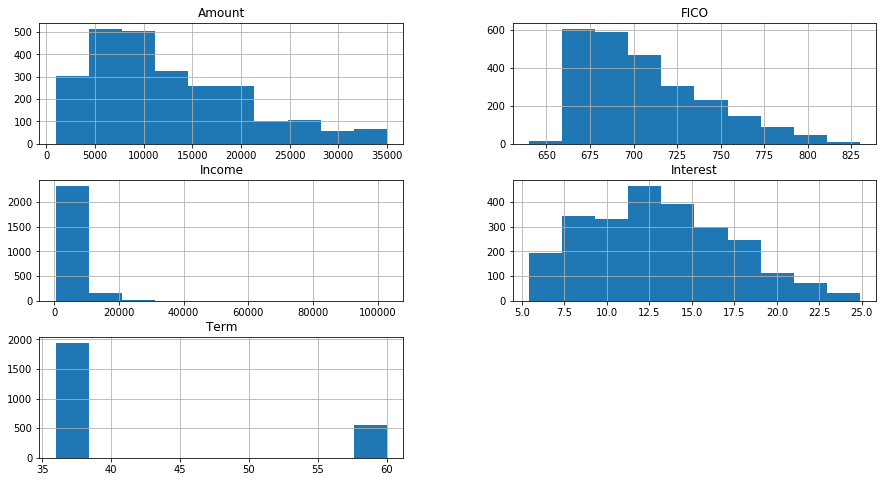

In [151]:
df.hist(figsize=(15, 8));

In [152]:
df.corr()

,Interest,FICO,Term,Income,Amount
Interest,1.000000,-0.708646,0.424041,0.013218,0.332411
FICO,-0.708646,1.000000,0.012850,0.121372,0.083618
Term,0.424041,0.012850,1.000000,0.073693,0.412133
Income,0.013218,0.121372,0.073693,1.000000,0.389300
Amount,0.332411,0.083618,0.412133,0.389300,1.000000


# Prepare data

In [153]:
y = df.Interest <= 9
X = df.drop(columns=['Interest'])

In [154]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
scalar = StandardScaler().fit(X_train)
X_train = scalar.transform(X_train)
X_test = scalar.transform(X_test)

/Users/chyld/.conda/envs/py37/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/chyld/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/chyld/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


In [155]:
print('\n'.join(sklearn.metrics.SCORERS.keys()))

explained_variance
r2
neg_median_absolute_error
neg_mean_absolute_error
neg_mean_squared_error
neg_mean_squared_log_error
accuracy
roc_auc
balanced_accuracy
average_precision
neg_log_loss
brier_score_loss
adjusted_rand_score
homogeneity_score
completeness_score
v_measure_score
mutual_info_score
adjusted_mutual_info_score
normalized_mutual_info_score
fowlkes_mallows_score
precision
precision_macro
precision_micro
precision_samples
precision_weighted
recall
recall_macro
recall_micro
recall_samples
recall_weighted
f1
f1_macro
f1_micro
f1_samples
f1_weighted


# Grid search

In [156]:
params = {
          'penalty': ['l2'], 
          'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
          'fit_intercept': [True, False],
          'C': np.logspace(-3,3)
         }
gs = GridSearchCV(LogisticRegression(), param_grid=params, scoring='neg_log_loss', cv=10, n_jobs=5).fit(X_train, y_train)
gs

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=5,
       param_grid={'penalty': ['l2'], 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 'fit_intercept': [True, False], 'C': array([1.00000e-03, 1.32571e-03, 1.75751e-03, 2.32995e-03, 3.08884e-03,
       4.09492e-03, 5.42868e-03, 7.19686e-03, 9.54095e-03, 1.26486e-02,
       1.67683e-02, 2.2230... 1.84207e+02, 2.44205e+02,
       3.23746e+02, 4.29193e+02, 5.68987e+02, 7.54312e+02, 1.00000e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_log_loss', verbose=0)

# Final model

In [157]:
model = LogisticRegression(**gs.best_params_).fit(X_train, y_train)

# Model performance

In [158]:
y_hat = model.predict(X_test)
p_hat = model.predict_proba(X_test)[:,1]

In [159]:
log_loss(y_test, p_hat)

0.22180606259511781

In [160]:
baseline = 1 - (y_test.sum() / y_test.size)
accuracy = accuracy_score(y_test, y_hat)
baseline, accuracy

(0.7849117174959872, 0.9085072231139647)

In [161]:
# TP / (TP + FP) # type 1 errors
precision_score(y_test, y_hat)

0.8468468468468469

In [162]:
# TP / (TP + FN) # type 2 errors
recall_score(y_test, y_hat)

0.7014925373134329

In [163]:
# https://en.wikipedia.org/wiki/F1_score
# harmonic mean of precision and recall
f1_score(y_test, y_hat)

0.7673469387755102

In [164]:
# [tn, fp] 
# [fn, tp]
confusion_matrix(y_test, y_hat)

array([[472,  17],
       [ 40,  94]])

# ROC curve

In [165]:
auc = roc_auc_score(y_test, p_hat)
auc

0.9596801269724995

In [166]:
fpr, tpr, thr = roc_curve(y_test, p_hat)
for th, fp, tp in zip(thr, fpr, tpr):
    print("{0:.2f} {1:.2f} {2:.2f}".format(th, fp, tp))

2.00 0.00 0.00
1.00 0.00 0.01
1.00 0.00 0.04
1.00 0.00 0.04
0.92 0.00 0.34
0.91 0.01 0.34
0.89 0.01 0.38
0.88 0.01 0.38
0.88 0.01 0.39
0.88 0.01 0.39
0.84 0.01 0.43
0.82 0.02 0.43
0.81 0.02 0.46
0.80 0.02 0.46
0.80 0.02 0.47
0.77 0.02 0.47
0.61 0.02 0.61
0.60 0.02 0.61
0.60 0.02 0.62
0.59 0.03 0.62
0.57 0.03 0.67
0.54 0.03 0.67
0.53 0.03 0.69
0.52 0.03 0.69
0.52 0.03 0.69
0.52 0.03 0.69
0.50 0.03 0.70
0.48 0.05 0.70
0.47 0.05 0.72
0.47 0.05 0.72
0.46 0.05 0.73
0.45 0.05 0.73
0.44 0.05 0.75
0.44 0.06 0.75
0.43 0.06 0.76
0.42 0.06 0.76
0.42 0.06 0.77
0.41 0.06 0.77
0.41 0.06 0.78
0.40 0.07 0.78
0.40 0.07 0.78
0.40 0.07 0.78
0.37 0.07 0.82
0.37 0.08 0.82
0.34 0.08 0.84
0.34 0.08 0.84
0.34 0.08 0.85
0.34 0.08 0.85
0.33 0.08 0.86
0.33 0.08 0.86
0.32 0.08 0.87
0.32 0.09 0.87
0.32 0.09 0.87
0.28 0.09 0.87
0.27 0.09 0.88
0.27 0.09 0.88
0.27 0.09 0.89
0.26 0.10 0.89
0.26 0.10 0.90
0.25 0.11 0.90
0.25 0.11 0.90
0.25 0.11 0.90
0.25 0.11 0.91
0.24 0.11 0.91
0.23 0.11 0.92
0.23 0.12 0.92
0.23 0.12 

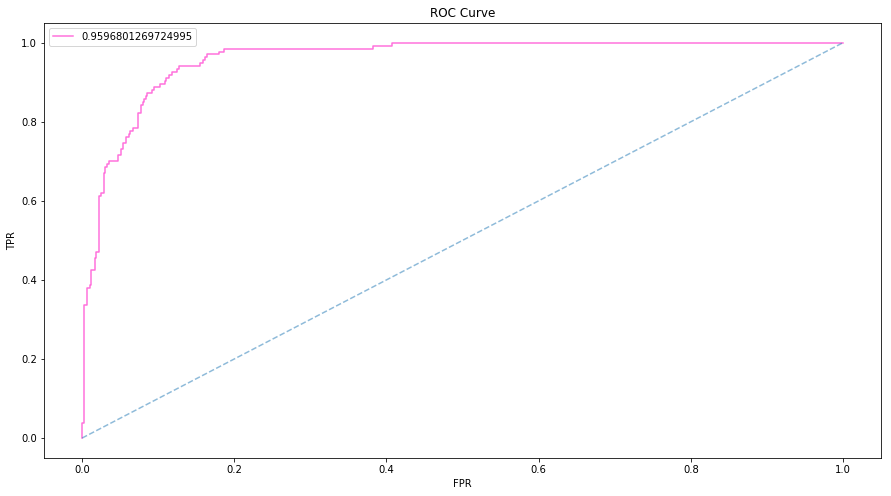

In [167]:
plt.figure(figsize = (15,8))
plt.plot(fpr, tpr, label=auc, color='#ff33cc', alpha=0.7)
plt.plot(np.linspace(0,1), np.linspace(0,1), linestyle='--', alpha=0.5)
plt.title('ROC Curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()

# Insight

In [168]:
acc, pre, rec, f1s = [], [], [], []
for i in range(100):
    y_hat = model.predict_proba(X_test)[:,1] > (i/100)
    acc.append(accuracy_score(y_test, y_hat))
    pre.append(precision_score(y_test, y_hat))
    rec.append(recall_score(y_test, y_hat))
    f1s.append(f1_score(y_test, y_hat))

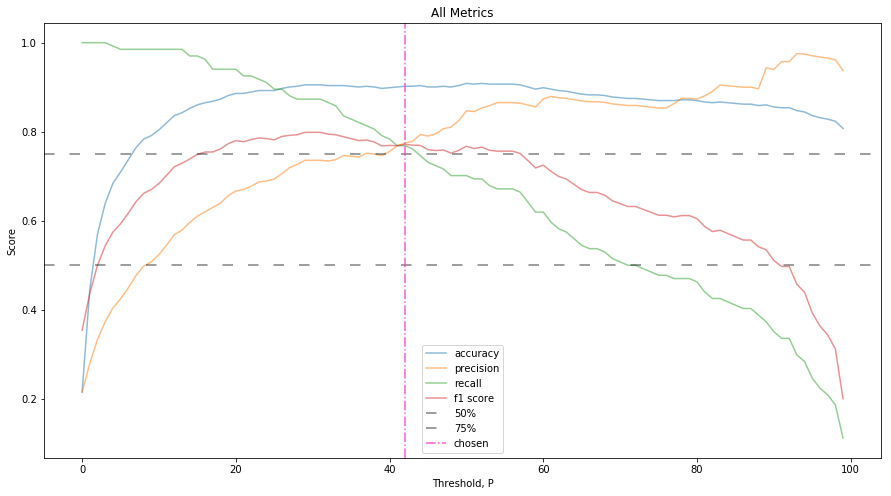

In [169]:
plt.figure(figsize = (15,8))
plt.plot(range(100), acc, label='accuracy', alpha=0.5)
plt.plot(range(100), pre, label='precision', alpha=0.5)
plt.plot(range(100), rec, label='recall', alpha=0.5)
plt.plot(range(100), f1s, label='f1 score', alpha=0.5)
plt.axhline(0.50, color='k', alpha=0.5, linestyle='--', dashes=(7,10), label='50%')
plt.axhline(0.75, color='k', alpha=0.5, linestyle='--', dashes=(7,10), label='75%')
plt.axvline(42, color='#ff33cc', alpha=0.8, linestyle='-.', label='chosen')
plt.title('All Metrics')
plt.xlabel('Threshold, P')
plt.ylabel('Score')
plt.legend()
plt.show()

# Summary

- Picked 42% as threshold
- 6%, 77% - FPR, TPR
- Balanced precision, recall and f1
- Maximized accuracy